<a href="https://colab.research.google.com/github/LouisBay/manduin-apps/blob/machine-learning/Landmark_Recognition_Notebook/Landmark_Classification(From_Scratch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import preprocess_input
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow as tf

import os, shutil, zipfile
import string
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import files
import random
from shutil import copyfile


## Create Directory, Download, & Extract Dataset

In [ ]:

BASE_DIR = '/content'
os.chdir(BASE_DIR)


In [ ]:
# Download the datasets
dataset_zip_path = os.path.join(BASE_DIR, 'Bangkit-Capstone-Dataset-main.zip')
if not os.path.exists(dataset_zip_path):
  !wget --no-check-certificate --content-disposition https://codeload.github.com/ridhwanhabib18/Bangkit-Capstone-Dataset/zip/refs/heads/main
else:
  print("Dataset already downloaded")

--2022-05-29 13:57:14--  https://codeload.github.com/ridhwanhabib18/Bangkit-Capstone-Dataset/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.112.9
Connecting to codeload.github.com (codeload.github.com)|140.82.112.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘Bangkit-Capstone-Dataset-main.zip’

Bangkit-Capstone-Da     [             <=>    ]  66.19M  23.9MB/s    in 2.8s    

2022-05-29 13:57:16 (23.9 MB/s) - ‘Bangkit-Capstone-Dataset-main.zip’ saved [69406082]



In [ ]:
dataset_main_dir = os.path.join(BASE_DIR, 'dataset')
if os.path.exists(dataset_main_dir):
  shutil.rmtree(dataset_main_dir)

os.makedirs(dataset_main_dir)

with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
  zip_ref.extractall(dataset_main_dir)

In [ ]:
branch = 'Bangkit-Capstone-Dataset-main/dataset/'
dataset_dir = os.path.join(dataset_main_dir, branch)

for dir in os.listdir(dataset_dir):
  class_dir = os.path.join(dataset_dir, dir)
  print('total images for', dir, 'is', len(os.listdir(class_dir)))

total images for prambanan is 194
total images for monjali is 88
total images for borobudur is 131
total images for lawangsewu is 115
total images for majt is 111
total images for tugujogja is 100


In [ ]:
borobudur_dir = os.path.join(dataset_dir, 'borobudur')
lawangsewu_dir = os.path.join(dataset_dir, 'lawangsewu')
majt_dir = os.path.join(dataset_dir, 'majt')
monjali_dir = os.path.join(dataset_dir, 'monjali')
prambanan_dir = os.path.join(dataset_dir, 'prambanan')
tugujogja_dir = os.path.join(dataset_dir, 'tugujogja')

borobudur_files = os.listdir(borobudur_dir)
print(borobudur_files[:5])

lawangsewu_files = os.listdir(lawangsewu_dir)
print(lawangsewu_files[:5])

majt_files = os.listdir(majt_dir)
print(majt_files[:5])

monjali_files = os.listdir(monjali_dir)
print(monjali_files[:5])

prambanan_files = os.listdir(prambanan_dir)
print(prambanan_files[:5])

tugujogja_files = os.listdir(tugujogja_dir)
print(tugujogja_files[:5])


['borobudur_006.jpg', 'borobudur_131.jpg', 'borobudur_090.jpg', 'borobudur_133.jpg', 'borobudur_115.jpg']
['lawangsewu_081.jpg', 'lawangsewu_025.jpg', 'lawangsewu_050.jpg', 'lawangsewu_019.jpg', 'lawangsewu_077.jpg']
['majt_095.jpg', 'majt_062.jpg', 'majt_045.jpg', 'majt_004.jpg', 'majt_106.jpg']
['monjali_030.jpg', 'monjali_085.jpg', 'monjali_062.jpg', 'monjali_032.jpg', 'monjali_054.jpg']
['prambanan_006.jpg', 'prambanan_107.jpg', 'prambanan_150.jpg', 'prambanan_136.jpg', 'prambanan_156.jpg']
['tugujogja_059.jpg', 'tugujogja_017.jpg', 'tugujogja_067.jpg', 'tugujogja_100.jpg', 'tugujogja_038.jpg']


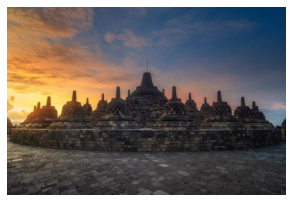

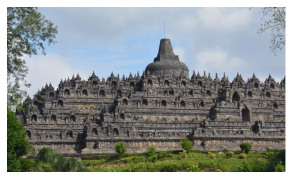

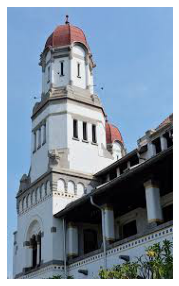

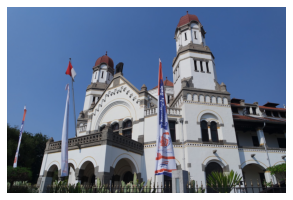

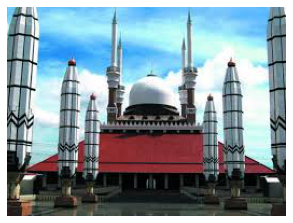

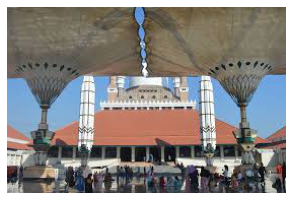

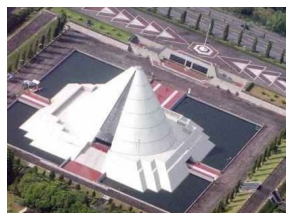

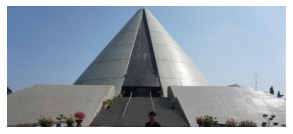

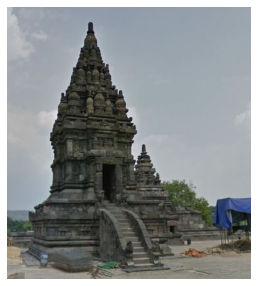

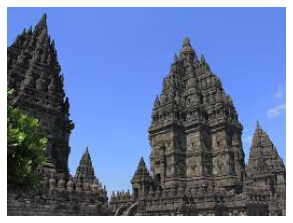

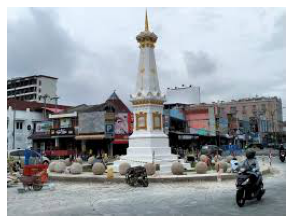

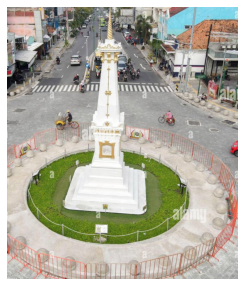

In [ ]:
%matplotlib inline

pic_index = 2

next_borobudur = [os.path.join(borobudur_dir, fname) 
                for fname in borobudur_files[pic_index-2:pic_index]]
next_lawangsewu = [os.path.join(lawangsewu_dir, fname) 
                for fname in lawangsewu_files[pic_index-2:pic_index]]
next_majt = [os.path.join(majt_dir, fname) 
                for fname in majt_files[pic_index-2:pic_index]]
next_monjali = [os.path.join(monjali_dir, fname) 
                for fname in monjali_files[pic_index-2:pic_index]]
next_prambanan = [os.path.join(prambanan_dir, fname) 
                for fname in prambanan_files[pic_index-2:pic_index]]
next_tugujogja = [os.path.join(tugujogja_dir, fname) 
                for fname in tugujogja_files[pic_index-2:pic_index]]



for i, img_path in enumerate(next_borobudur+next_lawangsewu+next_majt+next_monjali+next_prambanan+next_tugujogja):
  plt.figure(figsize=(5, 5))
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

#Dataset Preprocessing Using TF ImageDataGenerator

In [ ]:
branch = 'Bangkit-Capstone-Dataset-main/dataset/'
dataset_dir = os.path.join(dataset_main_dir, branch)

for dir in os.listdir(dataset_dir):
  class_dir = os.path.join(dataset_dir, dir)
  print('total images for', dir, 'is', len(os.listdir(class_dir)))

total images for prambanan is 194
total images for monjali is 88
total images for borobudur is 131
total images for lawangsewu is 115
total images for majt is 111
total images for tugujogja is 100


In [ ]:
landmark_dir = os.path.join(dataset_dir, 'landmark')
branch = 'Bangkit-Capstone-Dataset-main/dataset_split'
dataset_split_dir = os.path.join(dataset_main_dir, branch)

if os.path.exists(dataset_split_dir):
  shutil.rmtree(dataset_split_dir)

def create_train_test_dirs(root_path):

  os.makedirs(os.path.join(root_path, 'training'))
  os.makedirs(os.path.join(root_path, 'validation'))
  os.makedirs(os.path.join(root_path, 'testing'))

  train_dir = os.path.join(root_path, "training")
  validation_dir = os.path.join(root_path, "validation")
  test_dir = os.path.join(root_path, "testing")

  for dir in os.listdir(dataset_dir):
    os.makedirs(os.path.join(train_dir, dir))

  for dir in os.listdir(dataset_dir):
    os.makedirs(os.path.join(validation_dir, dir))
  
  for dir in os.listdir(dataset_dir):
    os.makedirs(os.path.join(test_dir, dir))
  
try:
  create_train_test_dirs(root_path=dataset_split_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [ ]:
for rootdir, dirs, files in os.walk(dataset_split_dir):
    for subdir in dirs:
        print(os.path.join(dataset_split_dir, subdir))

/content/dataset/Bangkit-Capstone-Dataset-main/dataset_split/validation
/content/dataset/Bangkit-Capstone-Dataset-main/dataset_split/training
/content/dataset/Bangkit-Capstone-Dataset-main/dataset_split/testing
/content/dataset/Bangkit-Capstone-Dataset-main/dataset_split/prambanan
/content/dataset/Bangkit-Capstone-Dataset-main/dataset_split/monjali
/content/dataset/Bangkit-Capstone-Dataset-main/dataset_split/borobudur
/content/dataset/Bangkit-Capstone-Dataset-main/dataset_split/lawangsewu
/content/dataset/Bangkit-Capstone-Dataset-main/dataset_split/majt
/content/dataset/Bangkit-Capstone-Dataset-main/dataset_split/tugujogja
/content/dataset/Bangkit-Capstone-Dataset-main/dataset_split/prambanan
/content/dataset/Bangkit-Capstone-Dataset-main/dataset_split/monjali
/content/dataset/Bangkit-Capstone-Dataset-main/dataset_split/borobudur
/content/dataset/Bangkit-Capstone-Dataset-main/dataset_split/lawangsewu
/content/dataset/Bangkit-Capstone-Dataset-main/dataset_split/majt
/content/dataset/Ban

In [ ]:
def split_data(SOURCE, TRAINING, VALIDATION, TESTING, SPLIT_SIZE):

  source = os.listdir(SOURCE)
  file_number = len(source)

  for file in source:
    if os.path.getsize(SOURCE+file) == 0:
      print("{} is zero length, so ignoring.".format(file))
      source.remove(file)

  random.sample(source, len(source))

  for index, file in enumerate(source): 
    if index < SPLIT_SIZE * file_number: 
      if index < 0.8 * file_number:
        copyfile(os.path.join(SOURCE, file), os.path.join(TRAINING, file))
      else:
        copyfile(os.path.join(SOURCE, file), os.path.join(VALIDATION, file))
    else: 
        copyfile(os.path.join(SOURCE, file), os.path.join(TESTING, file)) 

In [ ]:
#Already defined source directory
BOROBUDUR_SOURCE_DIR = os.path.join(dataset_dir, 'borobudur/')
LAWANGSEWU_SOURCE_DIR = os.path.join(dataset_dir, 'lawangsewu/')
MAJT_SOURCE_DIR = os.path.join(dataset_dir, 'majt/')
MONJALI_SOURCE_DIR = os.path.join(dataset_dir, 'monjali/')
PRAMBANAN_SOURCE_DIR = os.path.join(dataset_dir, 'prambanan/')
TUGUJOGJA_SOURCE_DIR = os.path.join(dataset_dir, 'tugujogja/')

TRAINING_DIR = os.path.join(dataset_split_dir, "training/")
TESTING_DIR = os.path.join(dataset_split_dir, "testing/")
VALIDATION_DIR = os.path.join(dataset_split_dir, "validation/")

#Training Directory
BOROBUDUR_TRAINING_DIR = os.path.join(TRAINING_DIR, "borobudur/")
LAWANGSEWU_TRAINING_DIR = os.path.join(TRAINING_DIR, "lawangsewu/")
MAJT_TRAINING_DIR = os.path.join(TRAINING_DIR, "majt/")
MONJALI_TRAINING_DIR = os.path.join(TRAINING_DIR, "monjali/")
PRAMBANAN_TRAINING_DIR = os.path.join(TRAINING_DIR, "prambanan/")
TUGUJOGJA_TRAINING_DIR = os.path.join(TRAINING_DIR, "tugujogja/")

#Testing Directory
BOROBUDUR_TESTING_DIR = os.path.join(TESTING_DIR, "borobudur/")
LAWANGSEWU_TESTING_DIR = os.path.join(TESTING_DIR, "lawangsewu/")
MAJT_TESTING_DIR = os.path.join(TESTING_DIR, "majt/")
MONJALI_TESTING_DIR = os.path.join(TESTING_DIR, "monjali/")
PRAMBANAN_TESTING_DIR = os.path.join(TESTING_DIR, "prambanan/")
TUGUJOGJA_TESTING_DIR = os.path.join(TESTING_DIR, "tugujogja/")

#Validation Directory
BOROBUDUR_VALIDATION_DIR = os.path.join(VALIDATION_DIR, "borobudur/")
LAWANGSEWU_VALIDATION_DIR = os.path.join(VALIDATION_DIR, "lawangsewu/")
MAJT_VALIDATION_DIR = os.path.join(VALIDATION_DIR, "majt/")
MONJALI_VALIDATION_DIR = os.path.join(VALIDATION_DIR, "monjali/")
PRAMBANAN_VALIDATION_DIR = os.path.join(VALIDATION_DIR, "prambanan/")
TUGUJOGJA_VALIDATION_DIR = os.path.join(VALIDATION_DIR, "tugujogja/")

# Define proportion of images used for training
split_size = .90

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(BOROBUDUR_SOURCE_DIR, BOROBUDUR_TRAINING_DIR, BOROBUDUR_VALIDATION_DIR, BOROBUDUR_TESTING_DIR, split_size)
split_data(LAWANGSEWU_SOURCE_DIR, LAWANGSEWU_TRAINING_DIR, LAWANGSEWU_VALIDATION_DIR, LAWANGSEWU_TESTING_DIR, split_size)
split_data(MONJALI_SOURCE_DIR, MONJALI_TRAINING_DIR, MONJALI_VALIDATION_DIR, MONJALI_TESTING_DIR, split_size)
split_data(MAJT_SOURCE_DIR, MAJT_TRAINING_DIR, MAJT_VALIDATION_DIR, MAJT_TESTING_DIR, split_size)
split_data(PRAMBANAN_SOURCE_DIR, PRAMBANAN_TRAINING_DIR, PRAMBANAN_VALIDATION_DIR, PRAMBANAN_TESTING_DIR, split_size)
split_data(TUGUJOGJA_SOURCE_DIR, TUGUJOGJA_TRAINING_DIR, TUGUJOGJA_VALIDATION_DIR, TUGUJOGJA_TESTING_DIR, split_size)

In [ ]:
for dir in os.listdir(TRAINING_DIR):
  print(f"There are {len(os.listdir(os.path.join(TRAINING_DIR, dir)))} images in " + dir + " for training")

print("\n")

for dir in os.listdir(VALIDATION_DIR):
  print(f"There are {len(os.listdir(os.path.join(VALIDATION_DIR, dir)))} images in " + dir + " for validation")

print("\n")

for dir in os.listdir(TESTING_DIR):
  print(f"There are {len(os.listdir(os.path.join(TESTING_DIR, dir)))} images in " + dir + " for testing")

There are 156 images in prambanan for training
There are 71 images in monjali for training
There are 105 images in borobudur for training
There are 92 images in lawangsewu for training
There are 89 images in majt for training
There are 80 images in tugujogja for training


There are 19 images in prambanan for validation
There are 9 images in monjali for validation
There are 13 images in borobudur for validation
There are 12 images in lawangsewu for validation
There are 11 images in majt for validation
There are 10 images in tugujogja for validation


There are 19 images in prambanan for testing
There are 8 images in monjali for testing
There are 13 images in borobudur for testing
There are 11 images in lawangsewu for testing
There are 11 images in majt for testing
There are 10 images in tugujogja for testing


In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  # Instantiate the ImageDataGenerator class
  train_datagen = ImageDataGenerator(rescale=1.0/255,
                                     rotation_range=15,
                                     width_shift_range=0.25,
                                     height_shift_range=0.25,
                                     shear_range=0.25,
                                     zoom_range=0.25,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(224, 224))

  validation_datagen = ImageDataGenerator( rescale = 1.0/255. )

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(224, 224))
  return train_generator, validation_generator

In [ ]:
# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, TESTING_DIR)

Found 593 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


# TF Image Classification Model

In [ ]:
model = tf.keras.models.Sequential([
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

# Print the model summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [ ]:
#Compile model

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Fit Model

In [ ]:
history = model.fit(
  train_generator,
  epochs=100,
  verbose=1,
  validation_data=validation_generator
)

Epoch 1/100
 4/19 [=====>........................] - ETA: 5s - loss: 2.0124 - accuracy: 0.1797

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


19/19 [==============================] - 24s 543ms/step - loss: 1.8235 - accuracy: 0.2125 - val_loss: 1.7236 - val_accuracy: 0.4028
Epoch 2/100
19/19 [==============================] - 10s 530ms/step - loss: 1.7106 - accuracy: 0.2648 - val_loss: 1.7055 - val_accuracy: 0.3750
Epoch 3/100
19/19 [==============================] - 10s 535ms/step - loss: 1.6886 - accuracy: 0.2513 - val_loss: 1.7057 - val_accuracy: 0.3194
Epoch 4/100
19/19 [==============================] - 10s 530ms/step - loss: 1.6703 - accuracy: 0.2816 - val_loss: 1.6096 - val_accuracy: 0.3472
Epoch 5/100
19/19 [==============================] - 12s 618ms/step - loss: 1.5901 - accuracy: 0.3322 - val_loss: 1.5143 - val_accuracy: 0.4444
Epoch 6/100
19/19 [==============================] - 10s 547ms/step - loss: 1.5150 - accuracy: 0.3440 - val_loss: 1.3281 - val_accuracy: 0.5139
Epoch 7/100
19/19 [==============================] - 10s 547ms/step - loss: 1.5062 - accuracy: 0.3862 - val_loss: 1.2514 - val_accuracy: 0.5278
Epoc

## Plot Result

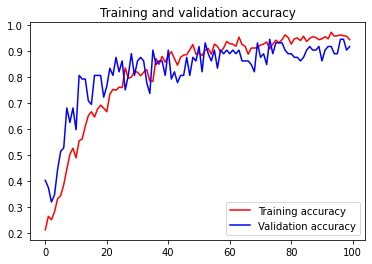

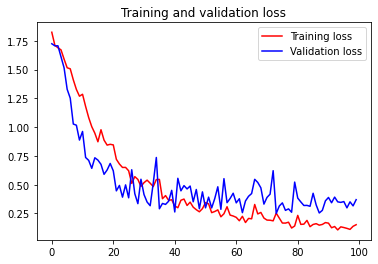

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#Predicting Image

In [ ]:
classes = train_generator.class_indices 
print(classes)

{'borobudur': 0, 'lawangsewu': 1, 'majt': 2, 'monjali': 3, 'prambanan': 4, 'tugujogja': 5}


Predicted : monjali (100.00%)


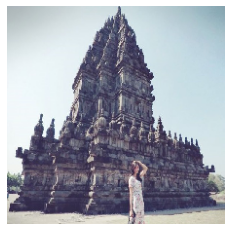

Predicted : tugujogja (100.00%)


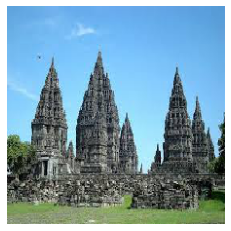

Predicted : monjali (100.00%)


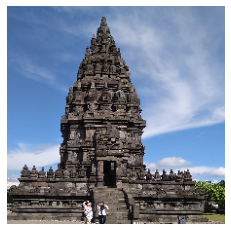

Predicted : tugujogja (96.94%)


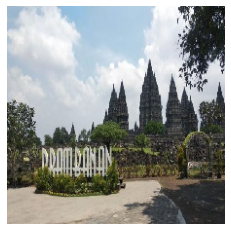

Predicted : monjali (100.00%)


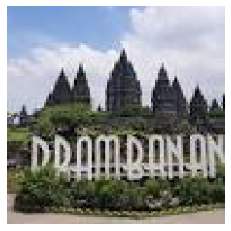

Predicted : monjali (100.00%)


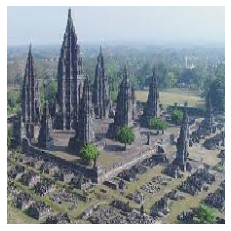

Predicted : monjali (100.00%)


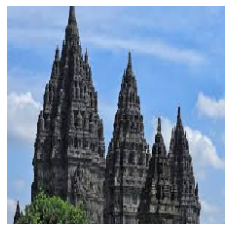

Predicted : monjali (100.00%)


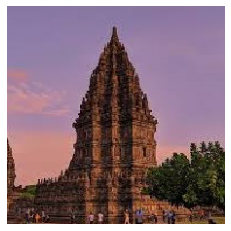

Predicted : tugujogja (100.00%)


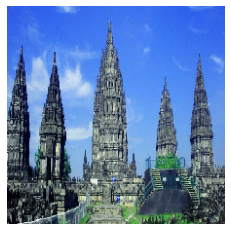

Predicted : monjali (79.71%)


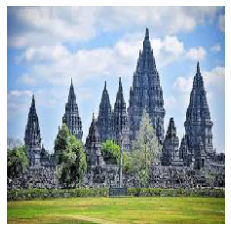

Predicted : monjali (99.98%)


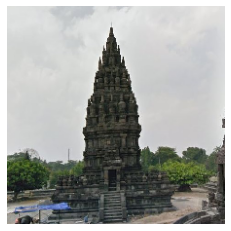

Predicted : monjali (100.00%)


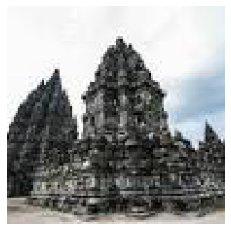

Predicted : monjali (100.00%)


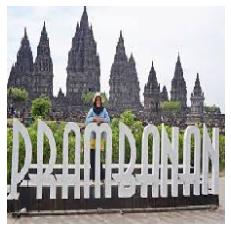

Predicted : monjali (100.00%)


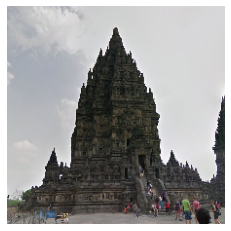

Predicted : tugujogja (99.84%)


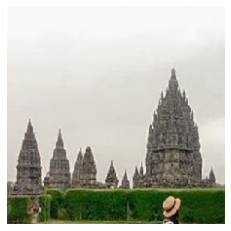

Predicted : monjali (100.00%)


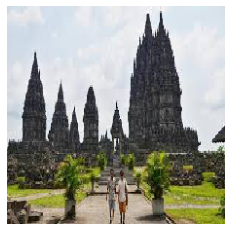

Predicted : monjali (100.00%)


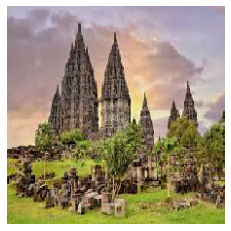

Predicted : monjali (100.00%)


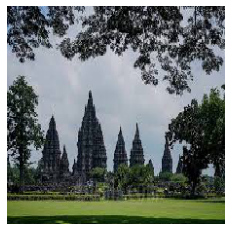

Predicted : monjali (100.00%)


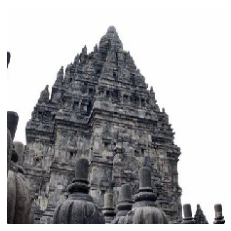

Predicted : tugujogja (100.00%)


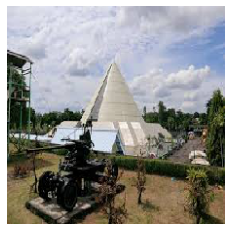

Predicted : tugujogja (95.65%)


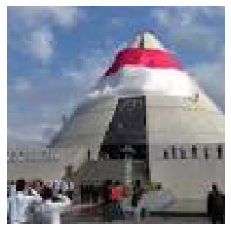

Predicted : tugujogja (100.00%)


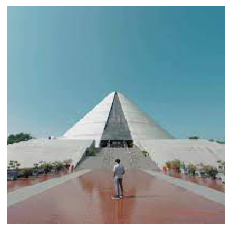

Predicted : tugujogja (99.85%)


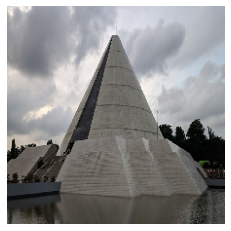

Predicted : tugujogja (67.53%)


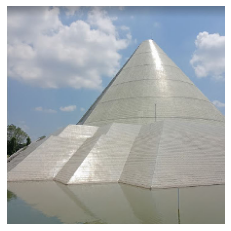

Predicted : monjali (99.94%)


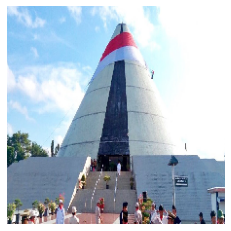

Predicted : tugujogja (100.00%)


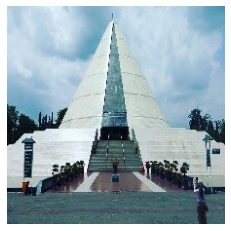

Predicted : monjali (100.00%)


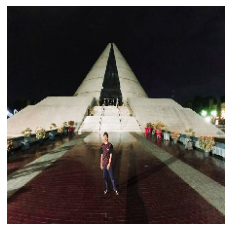

Predicted : monjali (100.00%)


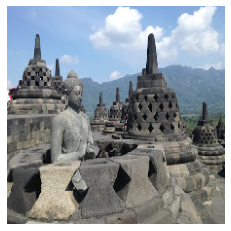

Predicted : monjali (100.00%)


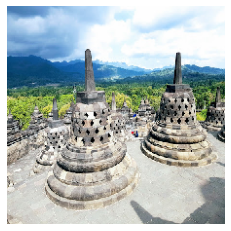

Predicted : monjali (100.00%)


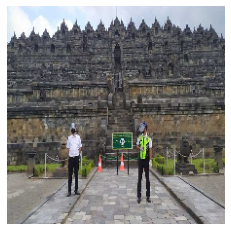

Predicted : monjali (100.00%)


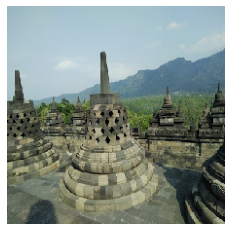

Predicted : monjali (100.00%)


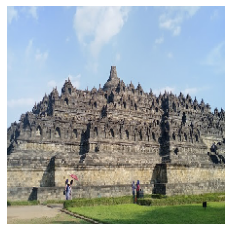

Predicted : monjali (100.00%)


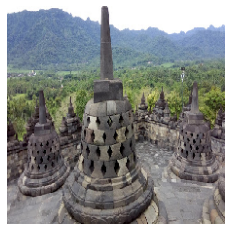

Predicted : tugujogja (100.00%)


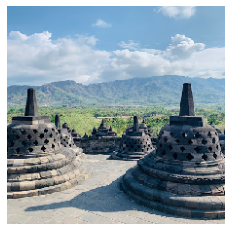

Predicted : monjali (100.00%)


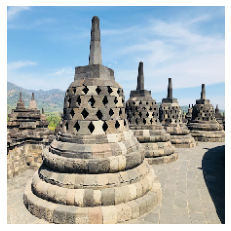

Predicted : tugujogja (100.00%)


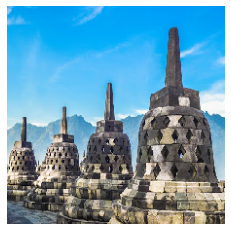

Predicted : monjali (100.00%)


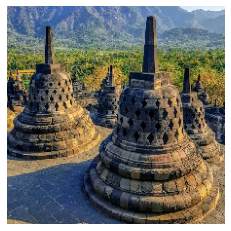

Predicted : tugujogja (100.00%)


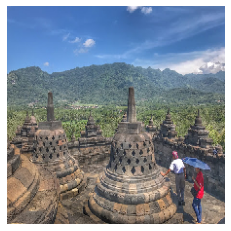

Predicted : monjali (100.00%)


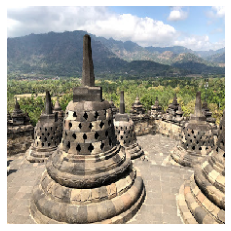

Predicted : tugujogja (100.00%)


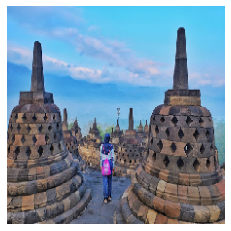

Predicted : monjali (100.00%)


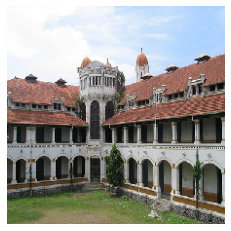

Predicted : monjali (100.00%)


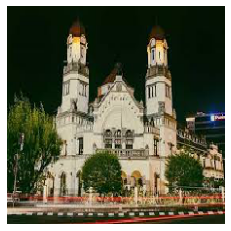

Predicted : monjali (100.00%)


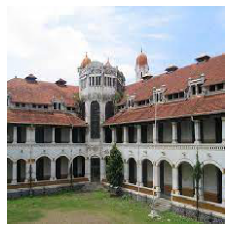

Predicted : monjali (100.00%)


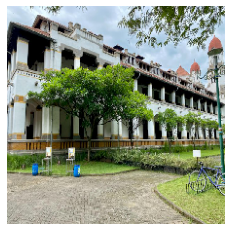

Predicted : tugujogja (100.00%)


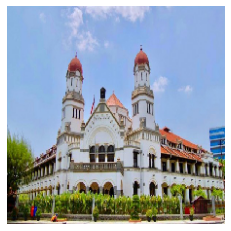

Predicted : monjali (100.00%)


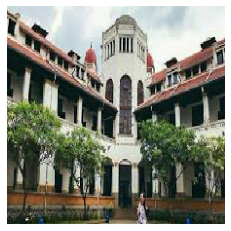

Predicted : monjali (100.00%)


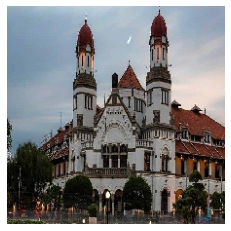

Predicted : monjali (100.00%)


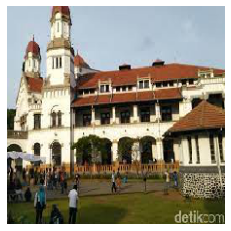

Predicted : tugujogja (100.00%)


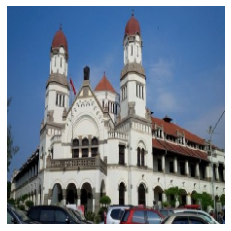

Predicted : monjali (100.00%)


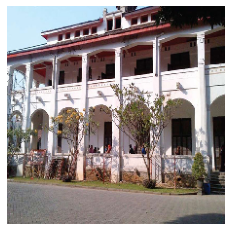

Predicted : tugujogja (100.00%)


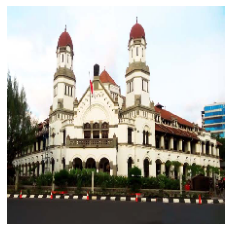

Predicted : tugujogja (100.00%)


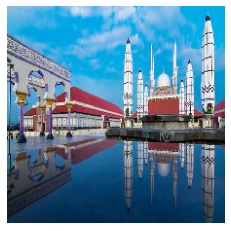

Predicted : monjali (100.00%)


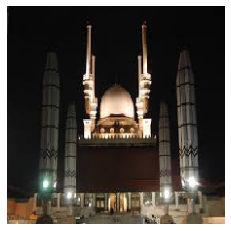

Predicted : tugujogja (100.00%)


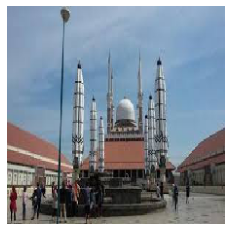

Predicted : tugujogja (90.64%)


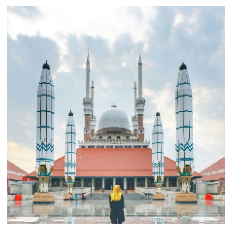

Predicted : tugujogja (100.00%)


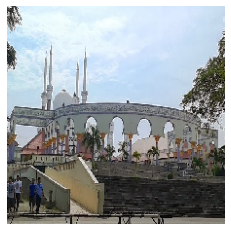

Predicted : monjali (88.52%)


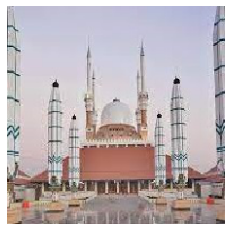

Predicted : tugujogja (83.49%)


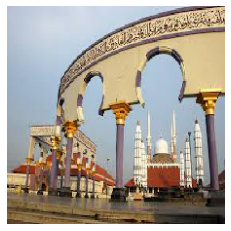

Predicted : tugujogja (100.00%)


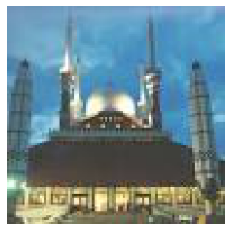

Predicted : tugujogja (100.00%)


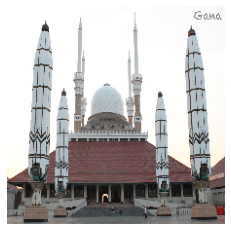

Predicted : tugujogja (100.00%)


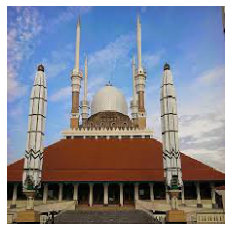

Predicted : tugujogja (100.00%)


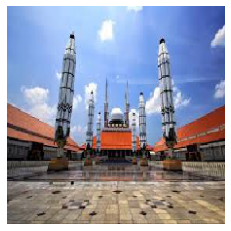

Predicted : tugujogja (96.60%)


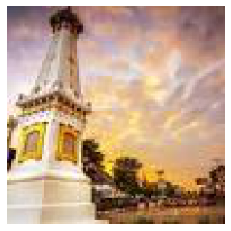

Predicted : monjali (99.86%)


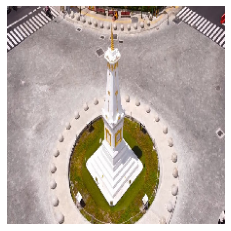

Predicted : tugujogja (97.69%)


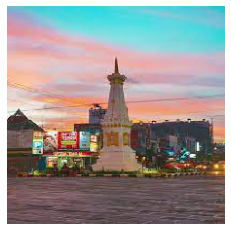

Predicted : monjali (100.00%)


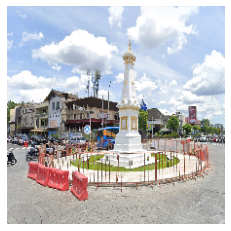

Predicted : tugujogja (100.00%)


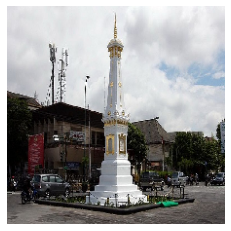

Predicted : tugujogja (100.00%)


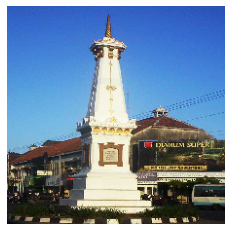

Predicted : tugujogja (100.00%)


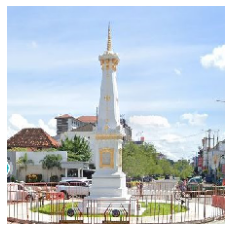

Predicted : tugujogja (100.00%)


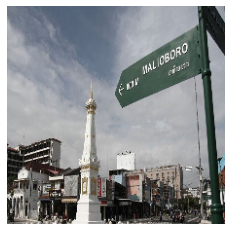

Predicted : tugujogja (100.00%)


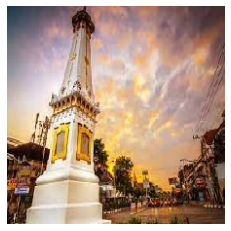

Predicted : monjali (100.00%)


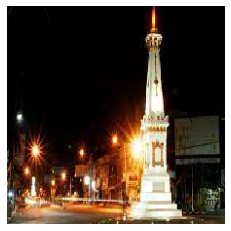

In [ ]:
labels = train_generator.class_indices.keys()

for folder in os.listdir(TESTING_DIR):
    for file_name in os.listdir(os.path.join(TESTING_DIR, folder)):

      file_dir = folder + "/" + file_name

      # predicting images
      path = os.path.join(TESTING_DIR, file_dir)
      img = image.load_img(path, target_size=(224, 224))
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
      x = preprocess_input(x)

      images = np.vstack([x])
      classes = model.predict(images, batch_size=10)
      proba = model.predict(images)[0]

      for (label, p) in zip(labels, proba):
        if p*100 > 40 :
          print("Predicted : {} ({:.2f}%)".format(label, p * 100))
      plt.imshow(img)
      plt.axis("off")
      plt.show()

#Exporting Model

In [ ]:
export_dir = 'saved_model/2'
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/2/assets


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()


In [ ]:
tflite_model_file = 'converted_model_non_transferlearning.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

In [ ]:
with open('labels_non_transferlearning.txt', 'w') as f:
    f.write('\n'.join(labels))

In [ ]:
try:
    from google.colab import files
    files.download('converted_model_non_transferlearning.tflite')
    files.download('labels_non_transferlearning.txt')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>